In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, IBMQ, Aer, __qiskit_version__
from qiskit.circuit.library import QFT, GraphState, GroverOperator
from qiskit.qasm import pi
from qiskit_nature.drivers import Molecule

import numpy as np
import matplotlib.pyplot as plt
import os.path
import time

from src.utils import *
from src.benchmarks import grover, qaoa, ghz, qft, qftentangled, shor, wstate, qpeinexact, qpeexact, graphstate, vqe, dj, hhl, ae, qwalk
from src.benchmarks.qiskit_application_optimization import routing, tsp
from src.benchmarks.qiskit_application_finance import portfolioqaoa, portfoliovqe, pricingcall, pricingput
from src.benchmarks.qiskit_application_ml import qgan
from src.benchmarks.qiskit_application_nature import groundstate, excitedstate

In [2]:
ibm_native_gates = FakeMontreal().configuration().basis_gates
rigetti_native_gates = ['rx','rz','cz']

In [3]:
benchmarks = [graphstate, ghz, qft, wstate, qpeinexact, qpeexact, dj, qftentangled, ae]# graphstate, ghz, qft, wstate, qpeinexact, qpeexact, dj, qftentangled, ae, shor,  qaoa, vqe,grover, qwalk, hhl] 
benchmarks_application = [portfolioqaoa, portfoliovqe] #pricingcall,pricingput,qgan,
benchmarks = []

In [4]:
n_min = 4
n_max = 80
stepsize = 2

save_hist = False
save_png = False

ancillary_mode ="v-chain"

In [5]:
def create_shor_benchmarks():
    small = [15,4] #18 qubits
    medium = [821, 4] #42 qubits
    large = [11777, 4] #58 qubits
    xlarge = [201209, 4] # 74 qubits
    benchmark_list = [small, medium, large]#, medium, large, xlarge]
    for n, a in benchmark_list:        
        try:
            # Creating the circuit on Algorithmic Description Layer
            qc = shor.create_circuit(n,a)
            num_qubits = len(qc.qubits)

            #filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
            #characteristics.append([filename_algo, num_qubits, depth]) 

            # Creating the circuit on target-independent Description Layer        
            filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_indep, num_qubits, depth]) 

            for gate_set, gate_set_name in gate_sets:
                try:          

                    for opt_level in range(4):                    

                        # Creating the circuit on target-dependent: native gates layer                
                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, num_qubits, save_png, save_hist, 
                                                                                  file_precheck=False)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             False, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])

                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             True, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])
                except Exception as e:
                    print("\n Problem occured in inner loop: ", "create_shor_benchmarks", n, gate_set_name, e)
        except Exception as e:
            print("\n Problem occured in outer loop: ", "create_shor_benchmarks", n, e)
            continue

In [6]:
def create_hhl_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(1,max_index):  
        try:
            # Creating the circuit on Algorithmic Description Layer
            qc = hhl.create_circuit(n)
            num_qubits = len(qc.qubits)

            #filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
            #characteristics.append([filename_algo, num_qubits, depth]) 

            # Creating the circuit on target-independent Description Layer        
            filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_indep, num_qubits, depth]) 

            for gate_set, gate_set_name in gate_sets:
                try:          

                    for opt_level in range(4):                    

                        # Creating the circuit on target-dependent: native gates layer                
                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, num_qubits, save_png, save_hist, 
                                                                                  file_precheck=False)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        # Creating the circuit on target-dependent: mapped layer
                        # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             False, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])

                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             True, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])
                except Exception as e:
                    print("\n Problem occured in inner loop: ", "create_hhl_benchmarks", n, gate_set_name, e)
        except Exception as e:
            print("\n Problem occured in outer loop: ", "create_hhl_benchmarks", n, e)
            continue

In [7]:
def create_routing_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(2,max_index): 
        try:
            # Creating the circuit on Algorithmic Description Layer
            qc = routing.create_circuit(n,2)
            num_qubits = (len(qc.qubits))

            #filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
            #characteristics.append([filename_algo, num_qubits, depth]) 

            # Creating the circuit on target-independent Description Layer        
            filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_indep, num_qubits, depth]) 

            for gate_set, gate_set_name in gate_sets:
                try:          

                    for opt_level in range(4):                    

                        # Creating the circuit on target-dependent: native gates layer                
                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, num_qubits, save_png, save_hist, 
                                                                                  file_precheck=False)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             False, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])

                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             True, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])
                except Exception as e:
                    print("\n Problem occured in inner loop: ", "create_routing_benchmarks", n, gate_set_name, e)
        except Exception as e:
            print("\n Problem occured in outer loop: ", "create_routing_benchmarks", n, e)
            continue

In [8]:
def create_tsp_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(3,max_index):    
        try:
            # Creating the circuit on Algorithmic Description Layer
            qc = tsp.create_circuit(n)
            num_qubits = (len(qc.qubits))

            #filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
            #characteristics.append([filename_algo, num_qubits, depth]) 

            # Creating the circuit on target-independent Description Layer        
            filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_indep, num_qubits, depth]) 

            for gate_set, gate_set_name in gate_sets:
                try:          

                    for opt_level in range(4):                    

                        # Creating the circuit on target-dependent: native gates layer                
                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, num_qubits, save_png, save_hist, 
                                                                                  file_precheck=False)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             False, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])

                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             True, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])
                except Exception as e:
                    print("\n Problem occured in inner loop: ", "create_tsp_benchmarks", n, gate_set_name, e)
        except Exception as e:
            print("\n Problem occured in outer loop: ", "create_tsp_benchmarks", n, e)
            continue

In [9]:
def create_groundstate_benchmarks():
    
    m_1 = Molecule(geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]], charge=0, multiplicity=1)
    m_2 = Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1)
    #m_3 = Molecule(geometry=[["O", [0.0, 0.0, 0.0]], ["H", [0.586, 0.757, .0]], ["H", [0.586, -0.757, .0]]], charge=0, multiplicity=1)
    
    molecules = [m_1, m_2]
    
    for count, molecule in enumerate(molecules):
        try:

            qc = groundstate.create_circuit(molecule)
            qc.name = qc.name + "-" + str(count)
            num_qubits = (len(qc.qubits))

            #filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
            #characteristics.append([filename_algo, num_qubits, depth]) 

            # Creating the circuit on target-independent Description Layer        
            filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_indep, num_qubits, depth]) 

            for gate_set, gate_set_name in gate_sets:
                try:          

                    for opt_level in range(4):
                        # Creating the circuit on target-dependent: native gates layer                
                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, num_qubits, save_png, save_hist, 
                                                                                  file_precheck=False)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             False, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])

                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             True, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])
                except Exception as e:
                    print("\n Problem occured in inner loop: ", "create_groundstate_benchmarks", molecule, gate_set_name, e)
        except Exception as e:
            print("\n Problem occured in outer loop: ", "create_groundstate_benchmarks", molecule, e)
            continue

In [10]:
def create_excitedstate_benchmarks():
    
    
    m_1 = Molecule(geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]], charge=0, multiplicity=1)
    m_2 = Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1)
    #m_3 = Molecule(geometry=[["O", [0.0, 0.0, 0.0]], ["H", [0.586, 0.757, .0]], ["H", [0.586, -0.757, .0]]], charge=0, multiplicity=1)
    
    molecules = [m_1, m_2]
    
    for count, molecule in enumerate(molecules):
        try:
            qc = excitedstate.create_circuit(molecule)
            qc.name = qc.name + "-" + str(count)
            num_qubits = (len(qc.qubits))

            #filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
            #characteristics.append([filename_algo, num_qubits, depth]) 

            # Creating the circuit on target-independent Description Layer        
            filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_indep, num_qubits, depth]) 

            for gate_set, gate_set_name in gate_sets:
                try:          

                    for opt_level in range(4):                    

                        # Creating the circuit on target-dependent: native gates layer                
                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, num_qubits, save_png, save_hist, 
                                                                                  file_precheck=False)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             False, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])

                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             True, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])
                except Exception as e:
                    print("\n Problem occured in inner loop: ", "create_excitedstate_benchmarks", molecule, gate_set_name, e)
        except Exception as e:
            print("\n Problem occured in outer loop: ", "create_excitedstate_benchmarks", molecule, e)
            continue

In [11]:
def create_pricingcall_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(3,max_index):   
        try:
            # Creating the circuit on Algorithmic Description Layer
            qc = pricingcall.create_circuit(n)
            num_qubits = str(len(qc.qubits))

            #filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
            #characteristics.append([filename_algo, num_qubits, depth]) 

            # Creating the circuit on target-independent Description Layer        
            filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_indep, num_qubits, depth]) 

            for gate_set, gate_set_name in gate_sets:
                try:          

                    for opt_level in range(4):                    

                        # Creating the circuit on target-dependent: native gates layer                
                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, num_qubits, save_png, save_hist, 
                                                                                  file_precheck=False)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             False, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])

                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             True, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])
                except Exception as e:
                    print("\n Problem occured in inner loop: ", "create_pricingcall_benchmarks", n, gate_set_name, e)
        except Exception as e:
            print("\n Problem occured in outer loop: ", "create_pricingcall_benchmarks", n, e)
            continue

In [12]:
def create_pricingput_benchmarks(max_index:int):
    # n is not the number of qubits in this case
    for n in range(3,max_index): 
        try:
            # Creating the circuit on Algorithmic Description Layer
            qc = pricingput.create_circuit(n)
            num_qubits = str(len(qc.qubits))

            #filename_algo, depth = handle_algorithm_layer(qc, num_qubits, save_png, save_hist)
            #characteristics.append([filename_algo, num_qubits, depth]) 

            # Creating the circuit on target-independent Description Layer        
            filename_indep, depth = get_indep_layer(qc, num_qubits, save_png, save_hist, file_precheck=False)
            characteristics.append([filename_indep, num_qubits, depth]) 

            for gate_set, gate_set_name in gate_sets:        
                try:             
                    for opt_level in range(4):    


                        # Creating the circuit on target-dependent: native gates layer                
                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, num_qubits, save_png, save_hist, 
                                                                                  file_precheck=False)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             False, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])

                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             True, save_png, save_hist, file_precheck=False)
                        characteristics.append([filename_mapped, n_actual, depth])
                except Exception as e:
                    print("\n Problem occured in inner loop: ", "create_pricingput_benchmarks", n, gate_set_name, e)
        except Exception as e:
            print("\n Problem occured in outer loop: ", "create_pricingput_benchmarks", n, e)
            continue

In [ ]:
characteristics = []
gate_sets = [(ibm_native_gates, "ibm"), (rigetti_native_gates, "rigetti")]

for benchmark in benchmarks+benchmarks_application:
    file_precheck = True
    print(benchmark)    
    
    # First treat all "special" benchmarks with n != num qubits or different constructor parameters    
    if benchmark == shor: 
        #create_shor_benchmarks()
        continue
    elif benchmark == hhl:  # 5 is max number which fits my RAM
        create_hhl_benchmarks(4)
        continue
    elif benchmark == pricingcall: 
        create_pricingcall_benchmarks(12) # max val is not tested yet, but indep layer generation fails
        continue
    elif benchmark == pricingput:
        create_pricingput_benchmarks(12) # max val is not tested yet, but indep layer generation fails
        continue
    elif benchmark == groundstate: 
        create_groundstate_benchmarks()
        continue
    elif benchmark == excitedstate: 
        create_excitedstate_benchmarks()
        continue
    elif benchmark == tsp: 
        create_tsp_benchmarks(4) # 5 is max number which fits my RAM
        continue
    elif benchmark == routing: 
        create_routing_benchmarks(4) # for a higher parameters than 5 it takes forever on my laptop
        continue
    
    for n in range(n_min, n_max, stepsize):  
        try:
            start = time.time()
            # Creating the circuit on Algorithmic Description Layer
            if (benchmark == grover or benchmark == qwalk):                
                qc = benchmark.create_circuit(n, ancillary_mode=ancillary_mode)
                qc.name = qc.name + "-" + ancillary_mode
                file_precheck = False
                n = qc.num_qubits

            else:
                qc = benchmark.create_circuit(n)

            

            #filename_algo, depth = handle_algorithm_layer(qc, n, save_png, save_hist)
            #characteristics.append([filename_algo, n, depth]) 

            end = time.time()
            time_diff = end-start
            if (time_diff > 60):
                print(qc.name + str(n) + " took too long")
                print(" time_diff: ", time_diff)
                break

            # Creating the circuit on target-independent Description Layer   
            start = time.time()

            filename_indep, depth = get_indep_layer(qc, n, save_png, save_hist, file_precheck)
            characteristics.append([filename_indep, n, depth]) 

            end = time.time()
            time_diff = end-start
            if (time_diff > 60 or depth>1000000):
                print(filename_indep + " took too long or depth to large")
                print("depth: ", depth, " time_diff: ", time_diff)
                break

            for gate_set, gate_set_name in gate_sets:
                try:      

                    for opt_level in range(4):                    

                        # Creating the circuit on target-dependent: native gates layer      

                        start = time.time()

                        filename_transpiled, depth, n_actual=get_transpiled_layer(qc, gate_set, gate_set_name, 
                                                                                  opt_level, n, save_png, save_hist, 
                                                                                  file_precheck=file_precheck)
                        characteristics.append([filename_transpiled, n_actual, depth]) 

                        end = time.time()
                        time_diff = end-start
                        if (time_diff > 60 or depth>1000000):
                            print(filename_transpiled + " took too long or depth to large")
                            print("depth: ", depth, " time_diff: ", time_diff)
                            break

                        start = time.time()
                        # Creating the circuit on target-dependent: mapped layer for both mapping schemes
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             False, save_png, save_hist, file_precheck=file_precheck)
                        characteristics.append([filename_mapped, n_actual, depth])

                        end = time.time()
                        time_diff = end-start
                        if (time_diff > 60 or depth>1000000):
                            print(filename_mapped + " took too long or depth to large")
                            print("depth: ", depth, " time_diff: ", time_diff)
                            break
                        
                        start = time.time()
                        
                        filename_mapped, depth = get_mapped_layer(qc, gate_set, gate_set_name, opt_level, n_actual,
                             True, save_png, save_hist, file_precheck=file_precheck)
                        characteristics.append([filename_mapped, n_actual, depth])
                        
                        end = time.time()
                        time_diff = end-start
                        if (time_diff > 60 or depth>1000000):
                            print(filename_mapped + " took too long or depth to large")
                            print("depth: ", depth, " time_diff: ", time_diff)
                            break

                except Exception as e:
                    print("\n Problem occured in inner loop: ", benchmark, n, gate_set_name, e)
        except Exception as e:
            print("\n Problem occured in outer loop: ", benchmark, n, e)
            continue

            

<module 'src.benchmarks.qiskit_application_finance.portfolioqaoa' from '/Users/nils/Documents/repos/MQTbench/src/benchmarks/qiskit_application_finance/portfolioqaoa.py'>
portfolioqaoa14 took too long
 time_diff:  1360.7056682109833
<module 'src.benchmarks.qiskit_application_finance.portfoliovqe' from '/Users/nils/Documents/repos/MQTbench/src/benchmarks/qiskit_application_finance/portfoliovqe.py'>


In [ ]:
characteristics = np.array(characteristics)
plt.scatter(x=characteristics[:,1].astype(int), y=characteristics[:,2].astype(int))
plt.yscale('log')
plt.title('Depth and Width of generated Benchmarks')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth');
plt.savefig("test")

In [ ]:
len(characteristics)

In [ ]:
width_depth_0=[]
width_depth_1=[]
width_depth_2=[]
width_depth_3=[]

for f in characteristics:
    if "algorithm" in f[0]:
        width_depth_0.append([f[1], f[2]])       

    elif "t-indep" in f[0]:
        width_depth_1.append([f[1], f[2]])  

    elif "transpiled" in f[0]:
        width_depth_2.append([f[1], f[2]])  
        
    elif "mapped" in f[0]:
        width_depth_3.append([f[1], f[2]])   


In [ ]:
import random
import numpy
from matplotlib import pyplot



width_depth_0 = np.array(width_depth_0)
width_depth_1 = np.array(width_depth_1)
width_depth_2 = np.array(width_depth_2)
width_depth_3 = np.array(width_depth_3)

plt.scatter(x=width_depth_0[:,0].astype(int), y=width_depth_0[:,1].astype(int), label="0")
plt.yscale('log')
plt.title('Algorithm Layer')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth')
plt.xlim([0, 200])
plt.ylim([0, 10200])
plt.savefig("layer_0.pdf")
pyplot.show();
plt.scatter(x=width_depth_1[:,0].astype(int), y=width_depth_1[:,1].astype(int), label="1")
plt.yscale('log')
plt.title('Target-independent Layer')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth')
plt.xlim([0, 200])
plt.ylim([0, 10200])
plt.savefig("layer_1.pdf")
pyplot.show();
plt.scatter(x=width_depth_2[:,0].astype(int), y=width_depth_2[:,1].astype(int), label="2")
plt.yscale('log')
plt.title('Target-dependent Layer with native gates')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth')
plt.xlim([0, 200])
plt.ylim([0, 10200])
plt.savefig("layer_2.pdf")
pyplot.show();
plt.scatter(x=width_depth_3[:,0].astype(int), y=width_depth_3[:,1].astype(int), label="3")
plt.yscale('log')
plt.title('Target-independent Layer with native gates and mapping')
plt.xlabel('# of Qubits')
plt.ylabel('Circuit Depth')
plt.xlim([0, 200])
plt.ylim([0, 10200])
plt.savefig("layer_3.pdf")
pyplot.show();


Qiskit Finance Test

In [ ]:

from src.benchmarks.qiskit_application_finance import portfolio_optimization_qaoa, portfolio_optimization_vqe, pricing_eur_call_opt, pricing_eur_put_opt
num_qubits_test = 5
a = pricing_eur_put_opt.create_circuit(num_qubits_test)
b = get_compiled_circuit(a, opt_level=2, basis_gates=basis_gates)
save_as_qasm(b, num_qubits_test, basis_gates)
c = get_compiled_circuit(b, opt_level=2, basis_gates=basis_gates, c_map=c_map)
save_as_qasm(c, num_qubits_test, basis_gates, True, c_map, backend.name() if backend.name() else "")

Qiskit Optimization Test

In [ ]:

from src.benchmarks.qiskit_application_optimization import vehicle_routing
num_qubits_test = 5
a = vehicle_routing.create_circuit(3,3)
#b = get_compiled_circuit(a, opt_level=2)
#save_as_qasm(b, num_qubits_test)
#c = get_compiled_circuit(b, opt_level=2, c_map=c_map)
#save_as_qasm(c, num_qubits_test, True)

Qiskit Machine Learning Test

In [ ]:
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

algorithm_globals.random_seed = seed

# Number training data samples
N = 1000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0., 3.])
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [3]
k = len(num_qubits)

In [ ]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 10
# Batch size
batch_size = 100

# Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(
    backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed
)

# Set entangler map
#entangler_map = [[0, 1]]


# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz",  reps=1) #entanglement=entangler_map,

# Set generator's initial parameters - in order to reduce the training time and hence the
# total running time for this notebook
#init_params = [3.0, 1.0, 0.6, 1.6]

# You can increase the number of training epochs and use random initial parameters.
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

In [ ]:
# Run qGAN
result = qgan.run(quantum_instance)

In [ ]:
params = qgan.generator.parameter_values

In [ ]:
params = qgan.generator.parameter_values
qc = qgan.generator.construct_circuit(params=params)
qc.draw()

In [ ]:
qgan.generator.generator_circuit.draw()

In [ ]:
#Plot the CDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

Qiskit Application Optimization: TSP and vehicle routing Test

In [ ]:
from src.benchmarks.qiskit_application_optimization import travelling_salesman, vehicle_routing

In [ ]:
qc = vehicle_routing.create_circuit(4,1)

In [ ]:
qc1, qp1 = vehicle_routing.create_circuit(4,2)

In [ ]:
qc2, qp2  = vehicle_routing.create_circuit(4,3)

In [ ]:
qc3, qp3  = vehicle_routing.create_circuit(4,4)

In [ ]:
from qiskit.quantum_info import Statevector
print(Statevector.from_instruction(qc1).equiv(Statevector.from_instruction(qc2)),
Statevector.from_instruction(qc1).equiv(Statevector.from_instruction(qc3)),
Statevector.from_instruction(qc3).equiv(Statevector.from_instruction(qc2)))

QGAN Test

In [ ]:
from src.benchmarks.qiskit_application_ml import qgan

In [ ]:
a = qgan.create_circuit(4)

In [ ]:
a.decompose().draw()

In [ ]:
qc.draw()

Qiskit Application Finance Test

In [ ]:
from src.benchmarks.qiskit_application_finance import portfolio_optimization_qaoa, portfolio_optimization_vqe, pricing_eur_call_opt, pricing_eur_put_opt

In [ ]:
b = portfolio_optimization_qaoa.create_circuit(5)

In [ ]:
b.draw()

In [ ]:
c = portfolio_optimization_vqe.create_circuit(4)
c.draw()

In [ ]:
d = pricing_eur_call_opt.create_circuit(4)
d.draw()

In [ ]:
e, iae = pricing_eur_put_opt.create_circuit(2)
e.draw()

In [ ]:
test1 = iae.construct_circuit(1)
test1.decompose().decompose().decompose().draw()

In [ ]:
test2 = iae.construct_circuit(2)
test2.decompose().decompose().decompose().draw()

In [ ]:
test1 == test2

Qiskit Application Nature Test

Random debugging

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister

n=5
ancillary_mode = "v-chain"
coin_state_preparation = None
n = n-1 # because one qubit is needed for the coin
coin = QuantumRegister(1, 'coin')
node = QuantumRegister(n, 'node')

n_anc = 0
if ancillary_mode == 'recursion' and n > 3:
    n_anc = 1
if (ancillary_mode == 'v-chain' or ancillary_mode == 'v-chain-dirty') and n > 2:
    n_anc = n - 2

if n_anc == 0:
    qc = QuantumCircuit(node, coin, name='qwalk')

    # coin state preparation
    if coin_state_preparation is not None:
        qc.append(coin_state_preparation, coin[:])

    for _ in range(depth):
        # Hadamard coin operator
        qc.h(coin)

        # controlled increment
        for i in range(0, n - 1):
            qc.mcx(coin[:] + node[i + 1:], node[i], mode=ancillary_mode)
        qc.cx(coin, node[n - 1])

        # controlled decrement
        qc.x(coin)
        qc.x(node[1:])
        for i in range(0, n - 1):
            qc.mcx(coin[:] + node[i + 1:], node[i], mode=ancillary_mode)
        qc.cx(coin, node[n - 1])
        qc.x(node[1:])
        qc.x(coin)
else:
    anc = AncillaRegister(n_anc, 'anc')
    qc = QuantumCircuit(node, coin, anc, name='qwalk')

    # coin state preparation
    if coin_state_preparation is not None:
        qc.append(coin_state_preparation, coin[:])

    for _ in range(depth):
        # Hadamard coin operator
        qc.h(coin)

        # controlled increment
        for i in range(0, n - 1):
            qc.mcx(coin[:] + node[i + 1:], node[i], mode=ancillary_mode, ancilla_qubits=anc[:])
        qc.cx(coin, node[n - 1])

        # controlled decrement
        qc.x(coin)
        qc.x(node[1:])
        for i in range(0, n - 1):
            qc.mcx(coin[:] + node[i + 1:], node[i], mode=ancillary_mode, ancilla_qubits=anc[:])
        qc.cx(coin, node[n - 1])
        qc.x(node[1:])
        qc.x(coin)

qc.measure_all()
qc.draw()

In [ ]:
qc

In [ ]:
qc1 = transpile(qc, optimization_level=1)

In [ ]:
a =qc1.decompose().qasm()

In [ ]:
b = QuantumCircuit.from_qasm_str(a)

In [ ]:
qc1.draw()

In [ ]:
b.draw()

In [ ]:
a = grover.create_circuit(10, ancillary_mode="v-chain")

In [ ]:
a.draw()

In [ ]:
b = grover.create_circuit(10, ancillary_mode="noancilla")

In [ ]:
b.draw()

In [ ]:
a.num_qubits

In [ ]:
m = Molecule(
    geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]], charge=0, multiplicity=1
)

In [ ]:
a = excitedstate.create_circuit(m)
a.draw()

In [ ]:
m= Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1)

In [ ]:
b = groundstate.create_circuit(m)
b.draw()

In [ ]:
m = Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["Be", [0.0, 0.0, 0.355]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1)
c = groundstate.create_circuit(m)
c.draw()

In [ ]:
m = Molecule(geometry=[["O", [0.0, 0.0, 0.0]], ["H", [0.586, 0.757, .0]], ["H", [0.586, -0.757, .0]]], charge=0, multiplicity=1)
c = groundstate.create_circuit(m, basis="sto6g")
c.draw()

In [ ]:
help(dj.create_circuit)

In [ ]:
m_1 = Molecule(geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]], charge=0, multiplicity=1)
m_2 = Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1)
m_3 = Molecule(geometry=[["O", [0.0, 0.0, 0.0]], ["H", [0.586, 0.757, .0]], ["H", [0.586, -0.757, .0]]], charge=0, multiplicity=1)

In [ ]:
for _ in range(100):
    b = np.random.randint(0, 2)
    print(b)

In [ ]:
print(b_str)

In [ ]:
print(b)

In [ ]:
dj.create_circuit(5).draw()

In [ ]:
a = shor.create_circuit(15,2)

In [ ]:
a.draw()

In [ ]:
qc = QuantumCircuit(3)

In [ ]:
tsp.create_circuit(3).draw()

In [ ]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0,1)
qc.h(1)
qc.cx(0,2)
qc.h(2)
qc.measure_all()
qc.draw()

In [ ]:
simulator = Aer.get_backend('aer_simulator')
result = simulator.run(qc, shots=1024).result()
counts = result.get_counts()

In [ ]:
plot_histogram(counts)

In [ ]:
m_1 = Molecule(geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 2.5]]], charge=0, multiplicity=1)
a = excitedstate.create_circuit(m_1)

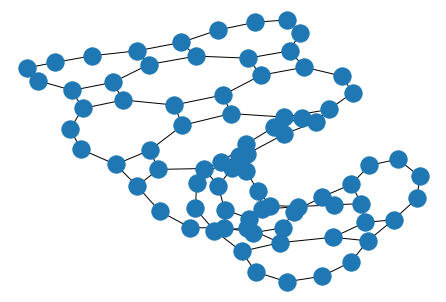

In [65]:
from src import utils
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
a = utils.get_rigetti_c_map(10)
G = nx.Graph(a)
nx.draw(G)

In [66]:
len(a)

212